<a href="https://colab.research.google.com/github/Saurabh1826/sleep-staging/blob/master/sleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import sys

from google.colab import drive
drive.mount('/content/gdrive')

# !wget -r -N -c -np https://physionet.org/files/sleep-accel/1.0.0/

file = 'gdrive/MyDrive/Sleep Files/1.0.0'

Mounted at /content/gdrive


In [2]:
# !git clone https://github.com/ojwalch/sleep_classifiers.git
# !cp -r 'gdrive/MyDrive/Sleep Files/1.0.0/heart_rate/' 'sleep_classifiers/data'
# !cp -r 'gdrive/MyDrive/Sleep Files/1.0.0/labels/' 'sleep_classifiers/data'
# !cp -r 'gdrive/MyDrive/Sleep Files/1.0.0/motion/' 'sleep_classifiers/data'
# !pip install -r sleep_classifiers/requirements.txt
# !pip install docx2txt

In [3]:
# !python sleep_classifiers/source/preprocessing/preprocessing_runner.py

In [2]:
!cp -r 'gdrive/MyDrive/Sleep Files/1.0.0/features' '.'

In [84]:
# Create feature matrix of the features

# Variable with name of the directory containing all the features
dirName = 'features'
# List that will be the feature matrix. It will be an array of feature matrices,
# where each feature matrix is for a single subject
features = []
# List that will be the labels vector. It will be an array of arrays, where each
# array is the label array for a single subject
labels = []
# Dict that maps the number of a file to all the files with that number
fileDict = {}

# Iterate over the directory dirName and put files in fileDict
dir = os.fsencode(dirName)
for file in os.listdir(dir) :
  fileName = os.fsdecode(file)
  if (not fileName.endswith('.out')) : continue
  fileNum = fileName.split('_')[0]
  if (fileNum in fileDict) :
    fileDict[fileNum].append(fileName)
  else :
    fileDict[fileNum] = [fileName]

# Iterate through fileDict and create the feature matrix
for subj, files in fileDict.items() :
  for fileName in files :
    if (fileName.split('_')[1] == 'cosine') :
      cosFile = open(os.path.join('.', 'features', fileName), 'r')
    elif (fileName.split('_')[1] == 'count') :
      cntFile = open(os.path.join('.', 'features', fileName), 'r')
    elif (fileName.split('_')[1] == 'hr') :
      hrFile = open(os.path.join('.', 'features', fileName), 'r')
    elif (fileName.split('_')[1] == 'psg') :
      labelsFile = open(os.path.join('.', 'features', fileName), 'r')
    else :
      timeFile = open(os.path.join('.', 'features', fileName), 'r')

  # Feature matrix and labels array for the current subject
  currFeats = []
  currLabels = []
  while (True) :
    nextLine = cosFile.readline()
    if (not nextLine) : break
    currFeats.append([float(nextLine), float(cntFile.readline()), float(hrFile.readline()), float(timeFile.readline())])
    currLabels.append(float(labelsFile.readline()))

  # Append currFeats, currLabels to features, labels
  features.append(np.array(currFeats))
  labels.append(np.array(currLabels))

  cosFile.close()
  cntFile.close()
  hrFile.close()
  labelsFile.close()
  timeFile.close()

In [85]:
# Normalize the features. Note that the normalization is being done for each subject
# separately

for i in range(len(features)) :
  features[i] = (features[i] - np.mean(features[i], axis=0)) / np.std(features[i], axis=0)

In [86]:
# Create the array binLabels, which is the exact same as labels, but is instead 1
# where labels is 5, and 0 otherwise (ie: binLabels is 0 for non-rem and 1 for
# rem)

binLabelsRem = []
for i in range(len(labels)) :
  currLabels = np.copy(labels[i])
  mask = currLabels == 5
  currLabels[mask] = 1
  currLabels[np.logical_not(mask)] = 0
  binLabelsRem.append(currLabels)

In [87]:
# Labels for sleep vs wake (wake is positive)

binLabelsWake = []
for i in range(len(labels)) :
  currLabels = np.copy(labels[i])
  mask = currLabels == 0
  currLabels[mask] = 1
  currLabels[np.logical_not(mask)] = 0
  binLabelsWake.append(currLabels)

In [88]:
# Labels for nrem vs non-nrem (nrem is positive)

binLabelsNrem = []
for i in range(len(labels)) :
  currLabels = np.copy(labels[i])
  for j in range(1, 5) :
    mask = currLabels == j
    currLabels[mask] = 1
  mask = currLabels == 1
  currLabels[mask] = 1
  currLabels[np.logical_not(mask)] = 0
  binLabelsNrem.append(currLabels)

In [90]:
# Create the array triLabels, which is the exact same as labels, but is instead 0
# where labels is 0, 2 where labels is 5, and 1 otherwise

triLabels = []
for i in range(len(labels)) :
  currLabels = np.copy(labels[i])
  for j in range(1, 5) :
    mask = currLabels == j
    currLabels[mask] = 1
  mask = currLabels == 5
  currLabels[mask] = 2
  triLabels.append(currLabels)

In [91]:
# Get number of positive and number of negative data points
numPositive = 0
numNegative = 0
for labels in binLabelsRem :
  numPositive += np.sum(labels)
  numNegative += len(labels) - np.sum(labels)

In [92]:
# Get number of wake, nrem, rem data points
numWakePts, numNremPts, numRemPts = 0, 0, 0
for labels in triLabels :
  numWakePts += len(labels[labels == 0])
  numNremPts += len(labels[labels == 1])
  numRemPts += len(labels[labels == 2])
print(f'Wake: {numWakePts}, Nrem: {numNremPts}, Rem: {numRemPts}')

Wake: 2152, Nrem: 17789, Rem: 5540


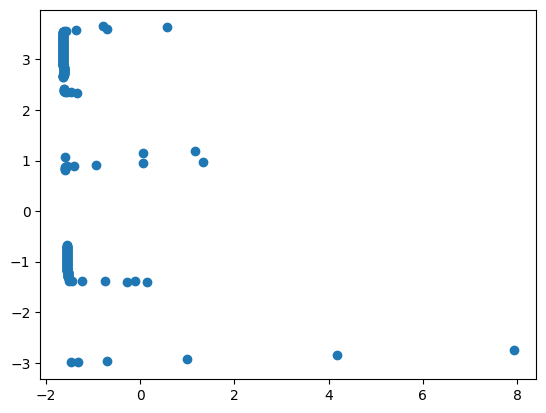

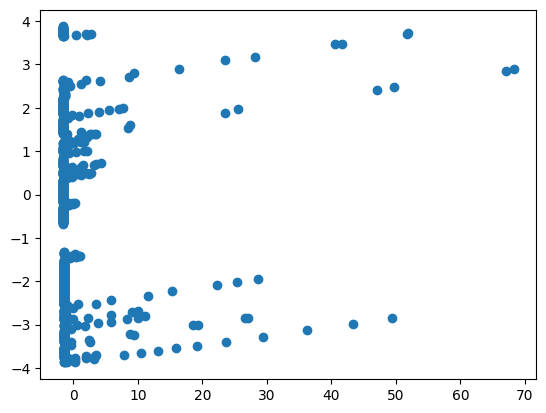

In [8]:
# Do PCA of the features
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(features[0])
pts = pca.transform(features[0])
mask = binLabels[0] == 1
plt.scatter(pts[mask, 0], pts[mask, 1])
plt.figure()
plt.scatter(pts[np.logical_not(mask), 0], pts[np.logical_not(mask), 1])

In [64]:
# Function to do leave one out cross validation
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

def crossVal(mdl, underSample=False, y=binLabels) :
  avgTruePos = 0
  avgTrueNeg = 0
  avgAcc = 0
  avgAuc = 0
  numPosTests, numNegTests = 0, 0
  for i in range(len(features)) :
    testX = features[i]
    testY = y[i]
    trainX = np.concatenate(features[:i] + features[i + 1:], axis=0)
    trainY = np.concatenate(y[:i] + y[i + 1:], axis=0)
    # testX = features[i]
    # testY = binLabels[i]
    # trainX = np.concatenate(features[:i] + features[i + 1:], axis=0)
    # trainY = np.concatenate(binLabels[:i] + binLabels[i + 1:], axis=0)
    # maskTrain = np.concatenate(binLabelsWake[:i] + binLabelsWake[i + 1:], axis=0)
    # trainX = trainX[maskTrain == 0]
    # trainY = trainY[maskTrain == 0]
    # testX = testX[binLabelsWake[i] == 0]
    # testY = testY[binLabelsWake[i] == 0]
    mask = testY == 1
    # print(i)
    numPositive = len(testX[mask])
    numNegative = len(testX) - numPositive

    mdlCopy = sklearn.base.clone(mdl)

    if (underSample) :
      trainMask = trainY == 1
      trainXPos = trainX[trainMask]
      trainXNeg = trainX[np.logical_not(trainMask)]
      trainYPos = trainY[trainMask]
      trainYNeg = trainY[np.logical_not(trainMask)]
      numTrainPos = len(trainXPos)
      inds = np.array([i for i in range(len(trainXNeg))])
      inds = np.random.choice(inds, numTrainPos)
      mdlCopy.fit(trainXPos.tolist() + trainXNeg[inds].tolist(), trainYPos.tolist() + trainYNeg[inds].tolist())
    else :
      mdlCopy.fit(trainX, trainY)

    if (numPositive) :
      tpr = mdlCopy.score(testX[mask], testY[mask])
      avgTruePos += tpr
      numPosTests += 1
      # print(f'True positive rate: {tpr}')
    if (numNegative) :
      tnr = mdlCopy.score(testX[np.logical_not(mask)], testY[np.logical_not(mask)])
      avgTrueNeg += tnr
      numNegTests += 1
      # print(f'True negative rate: {tnr}')
    if (numPositive and numNegative) :
      auc = roc_auc_score(testY, mdlCopy.predict_proba(testX)[:, 1])
      avgAuc += auc
      # print(f'AUC: {auc}')
    avgAcc += mdlCopy.score(testX, testY)
    # print()
  print(f'Avg true positive rate: {avgTruePos / numPosTests}')
  print(f'Avg true negative rate: {avgTrueNeg / numNegTests}')
  print(f'Avg accuracy: {avgAcc / len(features)}')
  print(f'Avg auc: {avgAuc / len(features)}')


def crossValTern(mdl, underSample=False) :
  avgWake, avgNrem, avgRem, avgAcc, avgCohenKappa = 0, 0, 0, 0, 0
  numWakeTests, numNremTests, numRemTests = 0, 0, 0
  for i in range(len(features)) :
    # print(i)
    testX = features[i]
    testY = triLabels[i]
    trainX = np.concatenate(features[:i] + features[i + 1:], axis=0)
    trainY = np.concatenate(triLabels[:i] + triLabels[i + 1:], axis=0)

    mdlCopy = sklearn.base.clone(mdl)

    if (underSample) :
      trainXWake = trainX[trainY == 0]
      trainXNrem = trainX[trainY == 1]
      trainXRem = trainX[trainY == 2]
      trainYWake = trainY[trainY == 0]
      trainYNrem = trainY[trainY == 1]
      trainYRem = trainY[trainY == 2]
      numSamples = min(len(trainXWake), len(trainXNrem), len(trainXRem))

      inds = np.array([i for i in range(len(trainXWake))])
      inds = np.random.choice(inds, numSamples)
      trainXWake = trainXWake[inds].tolist()
      trainYWake = trainYWake[inds].tolist()

      inds = np.array([i for i in range(len(trainXNrem))])
      inds = np.random.choice(inds, numSamples)
      trainXNrem = trainXNrem[inds].tolist()
      trainYNrem = trainYNrem[inds].tolist()

      inds = np.array([i for i in range(len(trainXRem))])
      inds = np.random.choice(inds, numSamples)
      trainXRem = trainXRem[inds].tolist()
      trainYRem = trainYRem[inds].tolist()

      mdlCopy.fit(trainXWake + trainXNrem + trainXRem, trainYWake + trainYNrem + trainYRem)
    else :
      mdlCopy.fit(trainX, trainY)

    maskWake = testY == 0
    numWake = len(testX[maskWake])
    maskNrem = testY == 1
    numNrem = len(testX[maskNrem])
    maskRem = testY == 2
    numRem = len(testX[maskRem])
    # print(numWake, numNrem, numRem)

    if (numWake) :
      wakeScore = mdlCopy.score(testX[maskWake], testY[maskWake])
      avgWake += wakeScore
      numWakeTests += 1
      # print(f'Wake score: {wakeScore}')
    if (numNrem) :
      nremScore = mdlCopy.score(testX[maskNrem], testY[maskNrem])
      avgNrem += nremScore
      numNremTests += 1
      # print(f'Nrem Score: {nremScore}')
    if (numRem) :
      remScore = mdlCopy.score(testX[maskRem], testY[maskRem])
      avgRem += remScore
      numRemTests += 1
      # print(f'Rem score: {remScore}')

    avgAcc += mdlCopy.score(testX, testY)
    avgCohenKappa += cohen_kappa_score(mdlCopy.predict(testX), testY)
    # print()
  print(f'Avg wake score: {avgWake / numWakeTests}')
  print(f'Avg nrem score: {avgNrem / numNremTests}')
  print(f'Avg rem score: {avgRem / numRemTests}')
  print(f'Avg accuracy: {avgAcc / len(features)}')
  print(f'Avg cohen kappa score: {avgCohenKappa / len(features)}')
  # return (avgWake / numWakeTests, avgNrem / numNremTests, avgRem / numRemTests, avgAcc / len(features))

In [159]:
# Function to, given trained wake, rem, and nrem classifiers, output a score of
# the custom model

# Function to give posterior probability
def posteriorProb(i1, i2, i3, wakePrior, remPrior, nremPrior, y) :
  if (i1 == 1 and i2 == 1 and i3 == 1) :
    y0 = 0.82 * 0.4 * 0.33 * wakePrior
    y1 = 0.19 * 0.4 * 0.67 * nremPrior
    y2 = 0.19 * 0.8 * 0.33 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s
  elif (i1 == 1 and i2 == 1 and i3 == 0) :
    y0 = 0.82 * 0.4 * 0.67 * wakePrior
    y1 = 0.19 * 0.4 * 0.33 * nremPrior
    y2 = 0.19 * 0.8 * 0.67 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s
  elif (i1 == 1 and i2 == 0 and i3 == 1) :
    y0 = 0.82 * 0.6 * 0.33 * wakePrior
    y1 = 0.19 * 0.6 * 0.67 * nremPrior
    y2 = 0.19 * 0.2 * 0.33 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s
  elif (i1 == 1 and i2 == 0 and i3 == 0) :
    y0 = 0.82 * 0.6 * 0.67 * wakePrior
    y1 = 0.19 * 0.6 * 0.33 * nremPrior
    y2 = 0.19 * 0.2 * 0.67 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s
  elif (i1 == 0 and i2 == 1 and i3 == 1) :
    y0 = 0.18 * 0.4 * 0.33 * wakePrior
    y1 = 0.81 * 0.4 * 0.67 * nremPrior
    y2 = 0.81 * 0.8 * 0.33 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s
  elif (i1 == 0 and i2 == 1 and i3 == 0) :
    y0 = 0.18 * 0.4 * 0.67 * wakePrior
    y1 = 0.81 * 0.4 * 0.33 * nremPrior
    y2 = 0.81 * 0.8 * 0.67 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s
  elif (i1 == 0 and i2 == 0 and i3 == 1) :
    y0 = 0.18 * 0.6 * 0.33 * wakePrior
    y1 = 0.81 * 0.6 * 0.67 * nremPrior
    y2 = 0.81 * 0.2 * 0.33 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s
  else :
    y0 = 0.18 * 0.6 * 0.67 * wakePrior
    y1 = 0.81 * 0.6 * 0.33 * nremPrior
    y2 = 0.81 * 0.2 * 0.67 * remPrior
    s = y0 + y1 + y2
    if (y == 0) : return y0 * wakePrior / s
    if (y == 1) : return y1 * nremPrior / s
    if (y == 2) : return y2 * remPrior / s


def sample(p) :
  return np.random.uniform() < p

def customScore(wakeClf, remClf, nremClf, testX, testY, wakePrior, remPrior, nremPrior, mlp=None) :
  score = 0
  # for i in range(len(testX)) :
  #   out = wakeClf.predict([testX[i]])[0]
  #   if (out == 1) : # Predicted to be awake
  #     score += 1 if testY[i] == 0 else 0
  #   else :
  #     out = remClf.predict([testX[i]])[0]
  #     if (out == 0) : # Predicted to be not rem
  #       score += 1 if testY[i] == 1 else 0
  #     else :
  #       score += 1 if testY[i] == 2 else 0

  for i in range(len(testX)) :
    out = wakeClf.predict([testX[i]])[0]
    if (out == 1) : # Predicted to be awake
      score += 1 if testY[i] == 0 else 0
    else :
      outRem = remClf.predict([testX[i]])[0]
      outNrem = nremClf.predict([testX[i]])[0]
      if ((not outRem) and outNrem) :
        pred = 1
      elif ((not outRem) and (not outNrem)) :
        pred = 2
      elif (outRem and outNrem) :
        pred = 1
      else :
        pred = 2
      score += 1 if testY[i] == pred else 0
      # if (out == 0) : # Predicted to be not rem
      #   score += 1 if testY[i] == 1 else 0
      # else :
      #   score += 1 if testY[i] == 2 else 0


  # for i in range(len(testX)) :
  #   outWake = wakeClf.predict([testX[i]])[0]
  #   outRem = remClf.predict([testX[i]])[0]
  #   outNrem = nremClf.predict([testX[i]])[0]
  #   posteriorWake = posteriorProb(outWake, outRem, outNrem, wakePrior, remPrior, nremPrior, 0)
  #   posteriorRem = posteriorProb(outWake, outRem, outNrem, wakePrior, remPrior, nremPrior, 2)
  #   posteriorNrem = posteriorProb(outWake, outRem, outNrem, wakePrior, remPrior, nremPrior, 1)
  #   pred = np.argmax(np.array([posteriorWake, posteriorNrem, posteriorRem]))
  #   # print([posteriorWake, posteriorNrem, posteriorRem])
  #   # print([outWake, outNrem, outRem])
  #   score += 1 if pred == testY[i] else 0

  # for i in range(len(testX)) :
  #   outWake = wakeClf.predict([testX[i]])[0]
  #   outRem = remClf.predict([testX[i]])[0]
  #   outNrem = nremClf.predict([testX[i]])[0]
  #   pred = mlp.predict([[outWake, outNrem, outRem]])[0]
  #   score += 1 if pred == testY[i] else 0

  return score / len(testX)

In [147]:
# Cross validation for custom model
from sklearn.neural_network import MLPClassifier

def warn(*args, **kwargs):
  pass
import warnings
warnings.warn = warn

def crossValCustom(wakeClf, remClf, nremClf, underSample=False) :
  avgWake, avgNrem, avgRem, avgAcc, avgCohenKappa = 0, 0, 0, 0, 0
  numWakeTests, numNremTests, numRemTests = 0, 0, 0
  for i in range(len(features)) :
    print(i)
    testX = features[i]
    testY = triLabels[i]
    trainX = np.concatenate(features[:i] + features[i + 1:], axis=0)
    trainY = np.concatenate(triLabels[:i] + triLabels[i + 1:], axis=0)
    trainYWake = np.concatenate(binLabelsWake[:i] + binLabelsWake[i + 1:], axis=0)
    trainYRem = np.concatenate(binLabelsRem[:i] + binLabelsRem[i + 1:], axis=0)
    trainYNrem = np.concatenate(binLabelsNrem[:i] + binLabelsNrem[i + 1:], axis=0)

    # print(len(trainX[trainYNrem == 1]), len(trainX[trainYNrem == 0]))

    wakeClfCopy = sklearn.base.clone(wakeClf)
    remClfCopy = sklearn.base.clone(remClf)
    nremClfCopy = sklearn.base.clone(nremClf)

    mlp = MLPClassifier(hidden_layer_sizes=(5,), random_state=0, max_iter=50)

    if (underSample) :

      trainXPosWake = trainX[trainYWake == 1]
      trainXNegWake = trainX[trainYWake == 0]
      numSamples = min(len(trainXPosWake), len(trainXNegWake))
      inds = np.array([i for i in range(len(trainXPosWake))])
      inds = np.random.choice(inds, numSamples)
      trainXPosWake = trainXPosWake[inds].tolist()
      inds = np.array([i for i in range(len(trainXNegWake))])
      inds = np.random.choice(inds, numSamples)
      trainXNegWake = trainXNegWake[inds].tolist()
      wakeClfCopy.fit(trainXPosWake + trainXNegWake, [1 for i in range(numSamples)] + [0 for i in range(numSamples)])

      trainXPosRem = trainX[trainYRem == 1]
      trainXNegRem = trainX[trainYRem == 0]
      numSamples = min(len(trainXPosRem), len(trainXNegRem))
      inds = np.array([i for i in range(len(trainXPosRem))])
      inds = np.random.choice(inds, numSamples)
      trainXPosRem = trainXPosRem[inds].tolist()
      inds = np.array([i for i in range(len(trainXNegRem))])
      inds = np.random.choice(inds, numSamples)
      trainXNegRem = trainXNegRem[inds].tolist()
      remClfCopy.fit(trainXPosRem + trainXNegRem, [1 for i in range(numSamples)] + [0 for i in range(numSamples)])

      trainXPosNrem = trainX[trainYNrem == 1]
      trainXNegNrem = trainX[trainYNrem == 0]
      numSamples = min(len(trainXPosNrem), len(trainXNegNrem))
      inds = np.array([i for i in range(len(trainXPosNrem))])
      inds = np.random.choice(inds, numSamples)
      trainXPosNrem = trainXPosNrem[inds].tolist()
      inds = np.array([i for i in range(len(trainXNegNrem))])
      inds = np.random.choice(inds, numSamples)
      trainXNegNrem = trainXNegNrem[inds].tolist()
      nremClfCopy.fit(trainXPosNrem + trainXNegNrem, [1 for i in range(numSamples)] + [0 for i in range(numSamples)])




      # trainXWake = trainX[trainY == 0]
      # trainXNrem = trainX[trainY == 1]
      # trainXRem = trainX[trainY == 2]
      # trainYWake = trainY[trainY == 0]
      # trainYNrem = trainY[trainY == 1]
      # trainYRem = trainY[trainY == 2]
      # numSamples = min(len(trainXWake), len(trainXNrem), len(trainXRem))

      # inds = np.array([i for i in range(len(trainXWake))])
      # inds = np.random.choice(inds, numSamples)
      # trainXWake = trainXWake[inds].tolist()
      # trainYWake = trainYWake[inds].tolist()

      # inds = np.array([i for i in range(len(trainXNrem))])
      # inds = np.random.choice(inds, numSamples)
      # trainXNrem = trainXNrem[inds].tolist()
      # trainYNrem = trainYNrem[inds].tolist()

      # inds = np.array([i for i in range(len(trainXRem))])
      # inds = np.random.choice(inds, numSamples)
      # trainXRem = trainXRem[inds].tolist()
      # trainYRem = trainYRem[inds].tolist()

      # trainXMlp = trainXWake + trainXNrem + trainXRem
      # trainMLP = np.array([[0 for j in range(3)] for i in range(len(trainXMlp))])
      # trainMLP[:, 0] = wakeClfCopy.predict(trainXMlp)
      # trainMLP[:, 1] = nremClfCopy.predict(trainXMlp)
      # trainMLP[:, 2] = remClfCopy.predict(trainXMlp)
      # mlp.fit(trainMLP, trainYWake + trainYNrem + trainYRem)

    else :
      wakeClfCopy.fit(trainX, trainYWake)
      remClfCopy.fit(trainX, trainYRem)
      nremClfCopy.fit(trainX, trainYNrem)

      # trainMLP = np.array([[0 for j in range(3)] for i in range(len(trainX))])
      # trainMLP[:, 0] = wakeClfCopy.predict(trainX)
      # trainMLP[:, 1] = nremClfCopy.predict(trainX)
      # trainMLP[:, 2] = remClfCopy.predict(trainX)
      # mlp.fit(trainMLP, trainY)

    maskWake = testY == 0
    numWake = len(testX[maskWake])
    maskNrem = testY == 1
    numNrem = len(testX[maskNrem])
    maskRem = testY == 2
    numRem = len(testX[maskRem])
    # print(numWake, numNrem, numRem)

    wakePrior = len(trainX[trainYWake == 1]) / len(trainX)
    remPrior = len(trainX[trainYRem == 1]) / len(trainX)
    nremPrior = len(trainX[trainYNrem == 1]) / len(trainX)
    wakePrior, nremPrior, remPrior = 0.19, 0.5, 0.32
    # print(wakePrior, remPrior, nremPrior)

    if (numWake) :
      wakeScore = customScore(wakeClfCopy, remClfCopy, nremClfCopy, testX[maskWake], testY[maskWake], wakePrior, remPrior, nremPrior, mlp)
      avgWake += wakeScore
      numWakeTests += 1
      print(f'Wake score: {wakeScore}')
    if (numNrem) :
      nremScore = customScore(wakeClfCopy, remClfCopy, nremClfCopy, testX[maskNrem], testY[maskNrem], wakePrior, remPrior, nremPrior, mlp)
      avgNrem += nremScore
      numNremTests += 1
      print(f'Nrem Score: {nremScore}')
    if (numRem) :
      remScore = customScore(wakeClfCopy, remClfCopy, nremClfCopy, testX[maskRem], testY[maskRem], wakePrior, remPrior, nremPrior, mlp)
      avgRem += remScore
      numRemTests += 1
      print(f'Rem score: {remScore}')

    avgAcc += customScore(wakeClfCopy, remClfCopy, nremClfCopy, testX, testY, wakePrior, remPrior, nremPrior, mlp)
    # avgCohenKappa += cohen_kappa_score(mdlCopy.predict(testX), testY)
    print()
  print(f'Avg wake score: {avgWake / numWakeTests}')
  print(f'Avg nrem score: {avgNrem / numNremTests}')
  print(f'Avg rem score: {avgRem / numRemTests}')
  print(f'Avg accuracy: {avgAcc / len(features)}')
  # print(f'Avg cohen kappa score: {avgCohenKappa / len(features)}')
  # return (avgWake / numWakeTests, avgNrem / numNremTests, avgRem / numRemTests, avgAcc / len(features))

In [ ]:
### PLAN:

# Incorporate the use of priors--REM is less likely than NREM?

# First run sleep vs wake classifier. If it gives wake, return wake. If it gives
# sleep, then run the rem and nrem classifiers and interpret their results
# using a bayesian framework with the prior on nrem vs rem. Go over the possible
# output combinations of the classifiers as well as the possible truths (rem/nrem),
# and determine the best way to interpret the output and predict the truth. For
# example, if the rem classifier gives false, then that there is a good chance
# that the truth is nrem, because the probability of the classifier returning true
# when the truth is rem is high

In [12]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

# Binary logistic regression
# class_weight = {0: 1, 1: 4}
# logisticRegressionClf = LogisticRegression(random_state=0,
#     class_weight=class_weight)

# crossVal(logisticRegressionClf)


# Ternary logistic regression
# class_weight = {0: 6, 1: 1.7, 2: 5}
class_weight = {0: 6.566, 1: 1.2, 2: 3.411}
logisticRegressionClf = LogisticRegression(random_state=0,
    class_weight=class_weight)

# crossValTern(logisticRegressionClf)

In [13]:
# Decision tree
from sklearn import tree

# Binary decision tree
# decisionTreeClf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, class_weight=class_weight)
# crossVal(decisionTreeClf)

# Binary decision tree for sleep vs wake
decisionTreeClf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
# crossVal(decisionTreeClf, underSample=True, y=binLabelsWake)

# Ternary decision tree
class_weight = {0: 3.89, 1: 1.87, 2: 3.19}
# decisionTreeClf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, class_weight=class_weight)
# crossValTern(decisionTreeClf)

In [161]:
# Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# Binary gradient boosting
gradBoostingClf = GradientBoostingClassifier(n_estimators=10, random_state=0)
# crossVal(gradBoostingClf, underSample=True)
# print()
# Gradient boosting for sleep vs wake
gradBoostingClf = GradientBoostingClassifier(n_estimators=20, random_state=0)
# crossVal(gradBoostingClf, underSample=True, y=binLabelsWake)
# print()

# Gradient boosting for nrem vs other
gradBoostingClf = GradientBoostingClassifier(n_estimators=20, random_state=0)
# crossVal(gradBoostingClf, underSample=True, y=binLabelsNrem)

# wakeClf = GradientBoostingClassifier(n_estimators=20, random_state=0)
# remClf = GradientBoostingClassifier(n_estimators=20, random_state=0)
# nremClf = GradientBoostingClassifier(n_estimators=20, random_state=0)
# crossValCustom(wakeClf, remClf, nremClf, underSample=True)


# Ternary gradient boosting
gradBoostingClf = GradientBoostingClassifier(n_estimators=10, random_state=0)
crossValTern(gradBoostingClf, underSample=True)

Avg wake score: 0.7692827298678923
Avg nrem score: 0.5564918777939792
Avg rem score: 0.6995518228826824
Avg accuracy: 0.5943500556902392
Avg cohen kappa score: 0.32024741179671606


In [162]:
# MLP

# Ternary mlp classification
mlpClf = MLPClassifier(hidden_layer_sizes=(5,10,), random_state=0, max_iter=50)
crossValTern(mlpClf, underSample=True)
# crossVal(mlpClf, underSample=True, y=binLabelsWake)

Avg wake score: 0.7081194979902528
Avg nrem score: 0.5155267316920554
Avg rem score: 0.7660691486793406
Avg accuracy: 0.5735718956605652
Avg cohen kappa score: 0.3008631586212978


In [163]:
# Ensemble algorithms
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Decision tree bagging classifier
decisionTreeBagging = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy', max_depth=3),
    max_samples=0.5, max_features=0.5)

# crossValTern(decisionTreeBagging, underSample=True)

# Logistic regression bagging classifier
logRegBagging = BaggingClassifier(LogisticRegression(random_state=0),
    max_samples=0.5, max_features=0.5)

# crossValTern(logRegBagging, underSample=True)

# Random forest
randomForestClf = RandomForestClassifier(n_estimators=10, criterion='entropy')
crossValTern(randomForestClf, underSample=True)

# Random forest for sleep vs wake
# randomForestClf = RandomForestClassifier(n_estimators=10, criterion='entropy')
# crossVal(randomForestClf, underSample=True, y=binLabelsWake)

Avg wake score: 0.6759784111237251
Avg nrem score: 0.6599037027969685
Avg rem score: 0.4210908529300664
Avg accuracy: 0.6041908716895615
Avg cohen kappa score: 0.25358993428696375


In [ ]:
# Autoencoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Encoder(nn.Module) :
  def __init__(self, latentDims, hiddenDims) :
    super(Encoder, self).__init__()
    self.linear1 = nn.Linear(4, hiddenDims)
    self.linear2 = nn.Linear(hiddenDims, latentDims)
  def forward(self, x) :
    # x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    return self.linear2(x)

class Decoder(nn.Module) :
  def __init__(self, latentDims, hiddenDims) :
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(latentDims, hiddenDims)
    self.linear2 = nn.Linear(hiddenDims, 4)
  def forward(self, x) :
    x = F.relu(self.linear1(x))
    # x = torch.sigmoid(self.linear2(x))
    x = self.linear2(x)
    return x

class Autoencoder(nn.Module) :
  def __init__(self, latentDims, hiddenDims) :
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(latentDims, hiddenDims)
    self.decoder = Decoder(latentDims, hiddenDims)
  def forward(self, x) :
    x = self.encoder(x)
    return self.decoder(x)

def train(autoencoder, data, epochs=40) :
  autoencoder = autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs) :
    epochLoss = 0
    for x in data :
      optim.zero_grad()
      x = x.to(device)
      x_hat = autoencoder(x)
      loss = ((x - x_hat) ** 2).sum()
      epochLoss += loss
      loss.backward()
      optim.step()
    print(f'Epoch #{epoch}: {epochLoss}')
  return autoencoder

def plotLatent(autoencoder, dataX, dataY, numBatches=2) :
  for i in range(len(dataX)) :
    x = dataX[i]
    y = dataY[i]
    z = autoencoder.encoder(x.to(device))
    z = z.cpu().detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y)
    if (i >= numBatches) :
      plt.colorbar()
      break

autoencoder = Autoencoder(2, 1000)
data = features.copy()
for i in range(len(data)) :
  data[i] = torch.tensor(data[i]).float()
autoencoder = train(autoencoder, data)

Epoch #0: 33776.73828125
Epoch #1: 13322.3515625
Epoch #2: 11554.4111328125
Epoch #3: 10254.447265625
Epoch #4: 10028.056640625
Epoch #5: 9668.5869140625
Epoch #6: 9350.724609375
Epoch #7: 9023.8095703125
Epoch #8: 8721.34765625
Epoch #9: 8452.9111328125
Epoch #10: 8236.748046875
Epoch #11: 8086.5283203125
Epoch #12: 8007.2705078125
Epoch #13: 7964.609375
Epoch #14: 7839.8291015625
Epoch #15: 7585.6181640625
Epoch #16: 7349.93505859375
Epoch #17: 7184.11083984375
Epoch #18: 7064.6220703125
Epoch #19: 6968.81298828125
Epoch #20: 6873.16455078125
Epoch #21: 6784.2275390625
Epoch #22: 6685.59130859375
Epoch #23: 6586.32666015625
Epoch #24: 6496.2900390625
Epoch #25: 6407.53955078125
Epoch #26: 6319.40625
Epoch #27: 6233.54541015625
Epoch #28: 6153.97705078125
Epoch #29: 6089.9697265625
Epoch #30: 6032.841796875
Epoch #31: 5978.5
Epoch #32: 5928.85791015625
Epoch #33: 5885.0048828125
Epoch #34: 5842.69091796875
Epoch #35: 5802.11669921875
Epoch #36: 5766.2646484375
Epoch #37: 5736.75585937

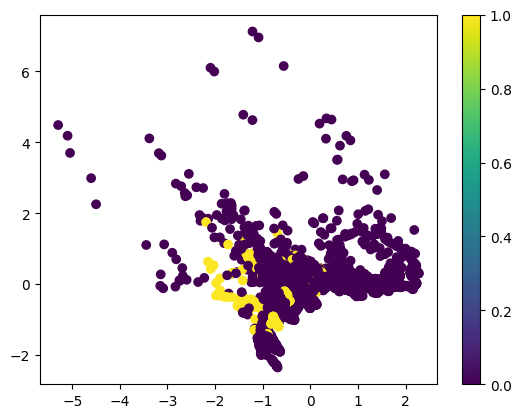

In [ ]:
dataX = features.copy()
for i in range(len(features)) :
  dataX[i] = torch.tensor(features[i]).float()
plotLatent(autoencoder, dataX, binLabelsRem)